In [1]:
#load libraries
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import os
import seaborn as sns
from sklearn.cluster import KMeans

from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler

In [2]:
np.random.seed(81391)

## Notes

Background intensity quantiles are calculated during the processing pipeline. Each marker has a subcellular location: nuclear or ring (i.e. cytoplasm). The background of a marker is defined as the opposite subcellular location of where it primarily localizes. Here, we use the third quantile of the background as our divisor. The ideal background depends on the accuracy of segmentation, and may vary in other datasets.

In [3]:
#set location of files
codedir = '/home/groups/graylab_share/OMERO.rdsStore/engje/Data/cycIF_ValidationStudies'

# Load Data

In [4]:
# 3 define samples to work with
ls_sample = ['JE-TMA-42','JE-TMA-43','JE-TMA-41',]
ls_dapi = ['DAPI12','DAPI12','DAPI8',]
dapi_thresh = 1000

In [5]:
# 4 import dataframe cell x and y
df_xy = pd.DataFrame()
for s_sample in ls_sample:
    print(f'features_{s_sample}_CentroidXY.csv')
    df_t = pd.read_csv(f'{codedir}/Data/features_{s_sample}_CentroidXY.csv',index_col=0)
    df_t['slide'] = s_sample
    if s_sample == 'JE-TMA-41':
        df_t.scene.replace({'scene13':'scene14'},inplace=True)
    df_xy = df_xy.append(df_t)
df_xy['slide_scene'] = df_xy.slide + '_' + df_xy.scene

features_JE-TMA-42_CentroidXY.csv
features_JE-TMA-43_CentroidXY.csv
features_JE-TMA-41_CentroidXY.csv


In [7]:
d_je_tma = {'scene01':'tonsil_01',
    'scene02':'HCC1143_02', 
    'scene03':'HCC3153_03', 
    'scene04':'NBreast_04',
    'scene05':'T47D_05',
    'scene06':'T47D_06',
    'scene07':'tonsil_07',
    'scene08':'BT474_08',
    'scene09':'BT474_09',
    'scene10':'AU565_10',
    'scene11':'AU565_11',
    'scene12':'NBreast_12',
    'scene13':'MDAMB-436_13',
    'scene14':'MDAMB-436_14',
 }

# clustering

In [8]:
# 4 import background quantiles (filtered)

df_bg =  pd.DataFrame()
for s_sample in ls_sample:
    print(f'features_{s_sample}_FilteredBackgroundQuantiles.csv')
    df_t = pd.read_csv(f'{codedir}/Data/features_{s_sample}_FilteredBackgroundQuantiles.csv',index_col=0)
    df_t.index = s_sample + '_' + df_t.index
    df_t['slide'] = s_sample
    df_bg = df_bg.append(df_t, sort=True)
#df_bg.head()

features_JE-TMA-42_FilteredBackgroundQuantiles.csv
features_JE-TMA-43_FilteredBackgroundQuantiles.csv
features_JE-TMA-41_FilteredBackgroundQuantiles.csv


In [9]:
#load af subtracted dataframe
df_mi = pd.DataFrame()
for idx, s_sample in enumerate(ls_sample):
    print(f'features_{s_sample}_FilteredMeanIntensity_{ls_dapi[idx]}_Nuclei{dapi_thresh}.csv')
    df_tt = pd.read_csv(f'{codedir}/Data/features_{s_sample}_FilteredMeanIntensity_{ls_dapi[idx]}_Nuclei{dapi_thresh}.csv',index_col=0)
    df_tt['slide'] = s_sample
    df_tt['scene'] = [item.split('_')[1] for item in df_tt.index]
    if s_sample == 'JE-TMA-41':
        df_tt.scene.replace({'scene13':'scene14'},inplace=True)
    df_mi = df_mi.append(df_tt,sort=True)
    
#add scene
df_mi['slide_scene'] = df_mi.slide + '_' + df_mi.scene

#filter
ls_columns = (df_mi.columns[df_mi.isna().sum()==0]).tolist()
df_mi = df_mi.loc[:,ls_columns]
df_mi = df_mi[df_mi.scene != 'scene12']
#(set(df_mi.slide_scene))

features_JE-TMA-42_FilteredMeanIntensity_DAPI12_Nuclei1000.csv
features_JE-TMA-43_FilteredMeanIntensity_DAPI12_Nuclei1000.csv
features_JE-TMA-41_FilteredMeanIntensity_DAPI8_Nuclei1000.csv


## Normalize
divide each TMA by mean third quantile of background for each marker

In [12]:
# pick mean of third quantile
df_bg3 = df_bg.groupby('slide').mean()#.loc[:,df_bg.columns.str.contains('_3')]
df_bg3 = df_bg3.loc[:,df_bg3.columns.str.contains('_3')]

df_bg3.columns = [item.split('_')[0] for item in df_bg3.columns]
ls_marker = df_bg3.columns[df_bg3.isna().sum()==0].tolist()

#make normalized dataframe

ls_slide = sorted(set(df_mi.slide))
ls_sub = ls_marker
ls_other = []
df_norm= pd.DataFrame()

d_thresh_record= {}

for s_slide in ls_slide:
    df_slide = pd.DataFrame()
    for s_marker in ls_marker:
        s_marker_loc = df_mi.columns[df_mi.columns.str.contains(f'{s_marker}_')][0]
        df_slide[s_marker_loc] = df_mi[df_mi.slide==s_slide].loc[:,s_marker_loc]/df_bg3.loc[s_slide,s_marker] #> i_thresh
        d_thresh_record.update({f'{s_slide}_{s_marker}':df_bg3.loc[s_slide,s_marker]})
    df_norm = df_norm.append(df_slide)
#df_norm.drop('cPARP_Nuclei',axis=1,inplace=True)

#raw data
df_raw = df_mi.loc[:,df_norm.columns]

# K means clustering
## all markers

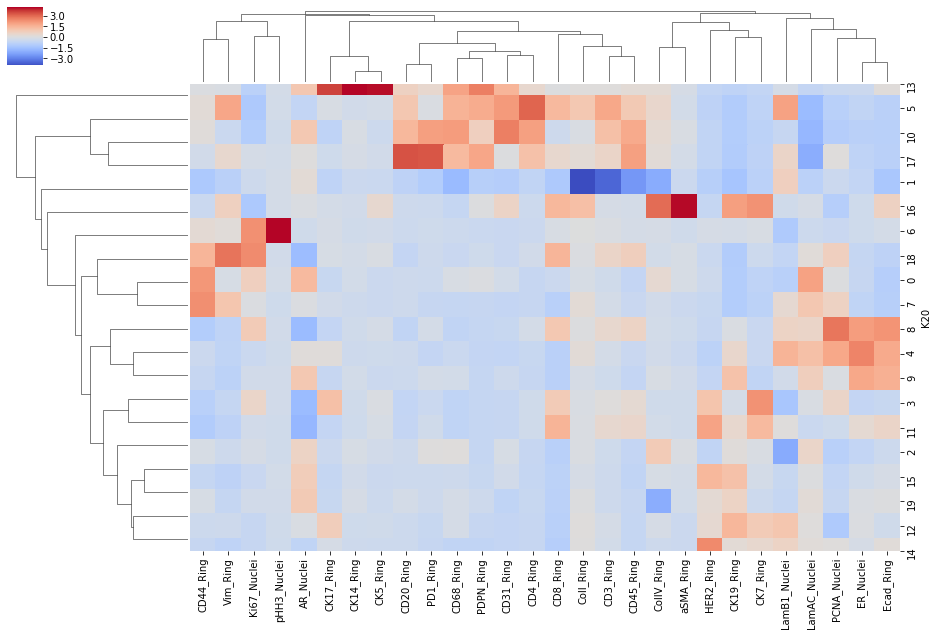

In [13]:
#raw
#kmeans clutering = all markers
k = 20
s_markers = 'All'
df_cluster = df_raw
#log 2 normalize
df_cluster = df_cluster + 1
df_cluster = np.log2(df_cluster)

#scale date
df_scale = scale(df_cluster)

#kmeans cluster
kmeans = KMeans(n_clusters=k, random_state=0).fit(df_scale)
df_raw[f'K{k}'] = list(kmeans.labels_)
g = sns.clustermap(df_raw.groupby(f'K{k}').mean(),cmap='coolwarm',z_score=1,figsize=(16,10))

#g.savefig(f'RAW_Kmeans{k}_{s_markers}.png')

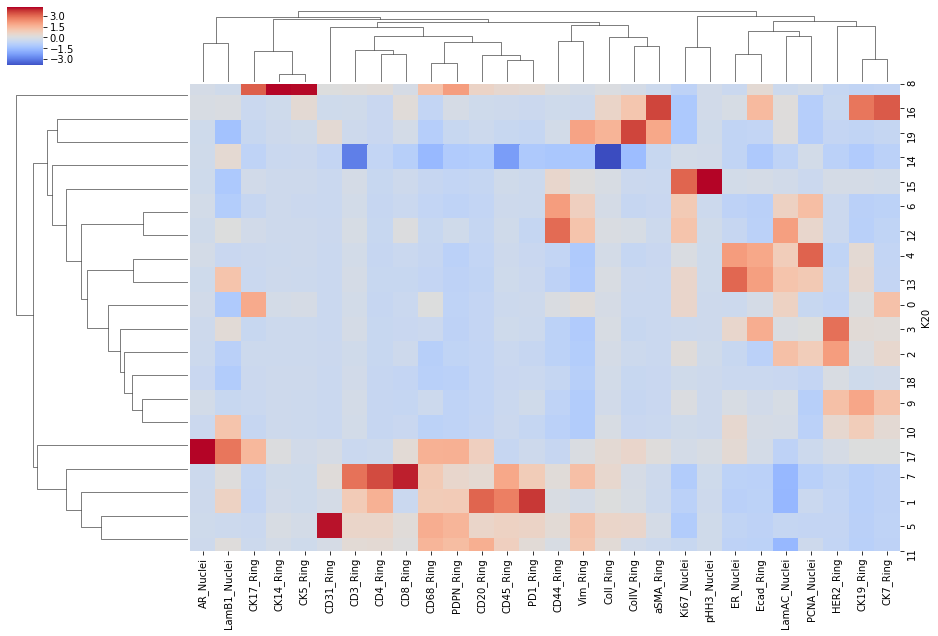

In [14]:
#normalized
#kmeans clutering = all markers
k = 20
s_markers = 'All'
df_cluster = df_norm
#log 2 normalize
df_cluster = df_cluster + 1
df_cluster = np.log2(df_cluster)

#scale date
df_scale = scale(df_cluster)

#kmeans cluster
kmeans = KMeans(n_clusters=k, random_state=0).fit(df_scale)
df_norm[f'K{k}'] = list(kmeans.labels_)
g = sns.clustermap(df_norm.groupby(f'K{k}').mean(),cmap='coolwarm',z_score=1,figsize=(16,10))

#g.savefig(f'Norm_Kmeans{k}_{s_markers}.png')

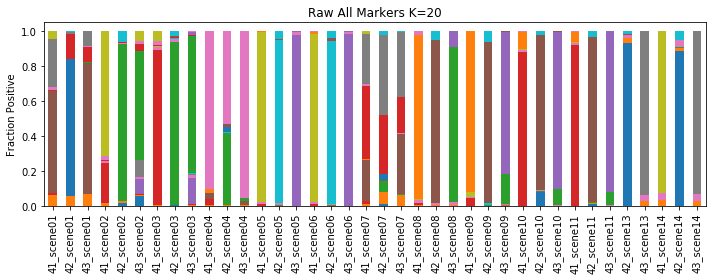

In [15]:
#raw - stacked barplot of kmeans cell fractions per core
df_xy_clust = df_xy.merge(df_raw.loc[:,[f'K{k}']],left_index=True,right_index=True)
#df_xy_clust = df_xy_clust[df_xy_clust.index.isin(df_cluster.index)]
df_prop = (df_xy_clust.groupby([f'K{k}','slide_scene']).DAPI_X.count())/(df_xy_clust.groupby(['slide_scene']).DAPI_X.count())
df_prop = df_prop.unstack().fillna(value=0).T
df_prop.index = [item.split('TMA-')[1] for item in df_prop.index]
df_prop.rename(d_je_tma,axis=0,inplace=True)
df_prop['slide'] =[item.split('_')[0] for item in df_prop.index]
df_prop['scene'] =[item.split('_')[1] for item in df_prop.index]
fig,ax=plt.subplots(figsize=(10,4))
df_prop.sort_values(['scene','slide']).plot(kind='bar',stacked=True,ax=ax,legend=False)
#ax.legend(loc='lower center', bbox_to_anchor=(0.5, 1.00),ncol=10, fancybox=True, shadow=True)
ax.set_ylabel('Fraction Positive')
ax.set_title(f'Raw {s_markers} Markers K={k}')
plt.tight_layout()
#fig.savefig(f'RAW_{s_markers}markers_{k}Clusters.png')


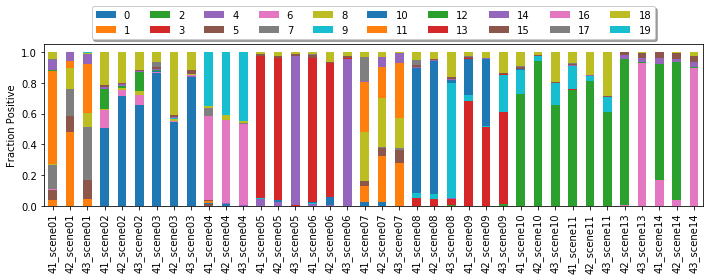

In [16]:
#norm  - stacked barplot of kmeans cell fractions per core
df_xy_clust = df_xy.merge(df_norm.loc[:,[f'K{k}']],left_index=True,right_index=True)
#df_xy_clust = df_xy_clust[df_xy_clust.index.isin(df_cluster.index)]
df_prop = (df_xy_clust.groupby([f'K{k}','slide_scene']).DAPI_X.count())/(df_xy_clust.groupby(['slide_scene']).DAPI_X.count())
df_prop = df_prop.unstack().fillna(value=0).T
df_prop.index = [item.split('TMA-')[1] for item in df_prop.index]
df_prop.rename(d_je_tma,axis=0,inplace=True)
df_prop['slide'] =[item.split('_')[0] for item in df_prop.index]
df_prop['scene'] =[item.split('_')[1] for item in df_prop.index]
fig,ax=plt.subplots(figsize=(10,4))
df_prop.sort_values(['scene','slide']).plot(kind='bar',stacked=True,ax=ax,legend=True)
ax.legend(loc='lower center', bbox_to_anchor=(0.5, 1.00),ncol=10, fancybox=True, shadow=True)
ax.set_ylabel('Fraction Positive')
ax.set_title(f'Normalized {s_markers} Markers K={k}')
plt.tight_layout()
#fig.savefig(f'Norm_{s_markers}markers_{k}Clusters_legend.png')


## tumor markers

Reducing the number of markers used for clustering improves the result. 

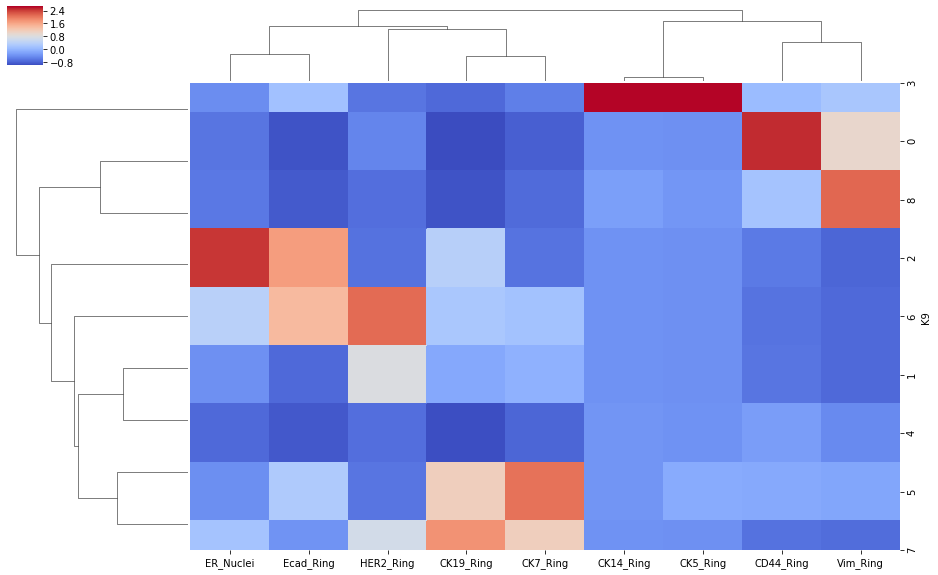

In [17]:
#kmeans clutering
df_cluster_norm = df_norm.loc[:,['CD44_Ring', 'CK14_Ring', 'CK19_Ring', 'CK5_Ring', 'CK7_Ring', 
        'ER_Nuclei', 'Ecad_Ring', 'HER2_Ring', #'Ki67_Nuclei',#'CK8_Ring','PCNA_Nuclei','CK17_Ring',
         'Vim_Ring']]
#kmeans clutering = all markers
k = 9
s_markers = 'Tumor'

#log 2 normalize
df_cluster_norm = df_cluster_norm + 1
df_cluster = np.log2(df_cluster_norm)

#scale date
df_scale = scale(df_cluster)

#kmeans cluster
kmeans = KMeans(n_clusters=k, random_state=0).fit(df_scale)
df_norm[f'K{k}'] = list(kmeans.labels_)
df_cluster_norm[f'K{k}'] = list(kmeans.labels_)
g = sns.clustermap(df_cluster_norm.groupby(f'K{k}').mean(),cmap='coolwarm',z_score=1,figsize=(16,10))

#g.savefig(f'Norm_Kmeans{k}_{s_markers}.png')

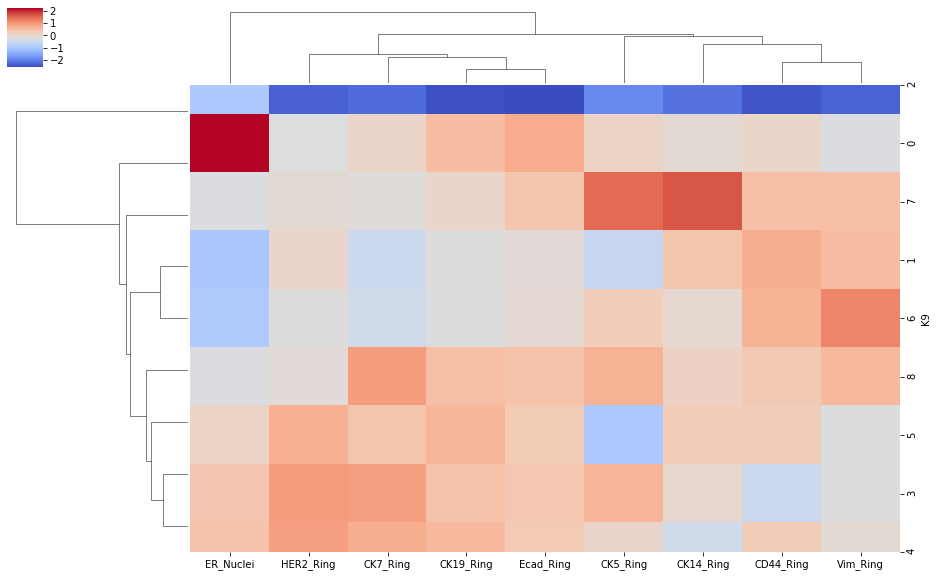

In [18]:
df_cluster_raw = df_raw.loc[:,['CD44_Ring', 'CK14_Ring', 'CK19_Ring', 'CK5_Ring', 'CK7_Ring', 
        'ER_Nuclei', 'Ecad_Ring', 'HER2_Ring', #'Ki67_Nuclei',#'CK8_Ring','PCNA_Nuclei','CK17_Ring',
         'Vim_Ring']]
#kmeans clutering = all markers
k = 9
s_markers = 'Tumor'

#log 2 normalize
df_cluster_raw = df_cluster_raw + 1
df_cluster_raw = np.log2(df_cluster_raw)

#scale date
df_scale = scale(df_cluster_raw)

#kmeans cluster
kmeans = KMeans(n_clusters=k, random_state=0).fit(df_scale)
df_raw[f'K{k}'] = list(kmeans.labels_)
df_cluster_raw[f'K{k}'] = list(kmeans.labels_)

g = sns.clustermap(df_cluster_raw.groupby(f'K{k}').mean(),cmap='coolwarm',z_score=1,figsize=(16,10))

#g.savefig(f'Raw_Kmeans{k}_{s_markers}.png')

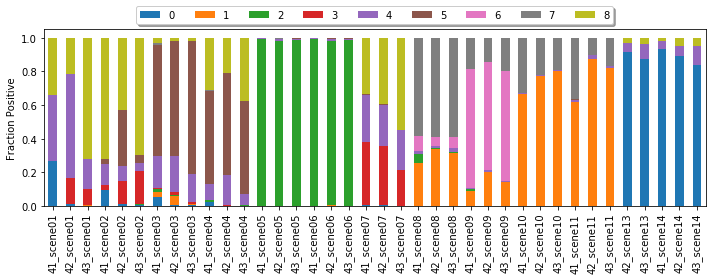

In [19]:
#stacked bar
#norm
df_xy_clust = df_xy.merge(df_cluster_norm.loc[:,[f'K{k}']],left_index=True,right_index=True)
#df_xy_clust = df_xy_clust[df_xy_clust.index.isin(df_cluster.index)]
df_prop = (df_xy_clust.groupby([f'K{k}','slide_scene']).DAPI_X.count())/(df_xy_clust.groupby(['slide_scene']).DAPI_X.count())
df_prop = df_prop.unstack().fillna(value=0).T
df_prop.index = [item.split('TMA-')[1] for item in df_prop.index]
df_prop.rename(d_je_tma,axis=0,inplace=True)
df_prop['slide'] =[item.split('_')[0] for item in df_prop.index]
df_prop['scene'] =[item.split('_')[1] for item in df_prop.index]
fig,ax=plt.subplots(figsize=(10,4))
df_prop.sort_values(['scene','slide']).plot(kind='bar',stacked=True,ax=ax,legend=True)
ax.legend(loc='lower center', bbox_to_anchor=(0.5, 1.00),ncol=10, fancybox=True, shadow=True)
ax.set_ylabel('Fraction Positive')
ax.set_title(f'Normalized {s_markers} Markers K={k}')
plt.tight_layout()
#fig.savefig(f'Norm_{s_markers}markers_{k}Clusters_legend.png')


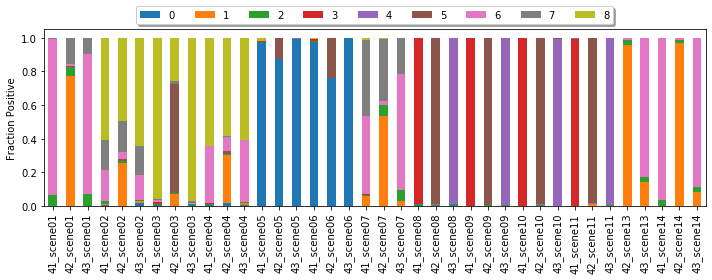

In [20]:
#stacked bar
#raw
df_xy_clust = df_xy.merge(df_cluster_raw.loc[:,[f'K{k}']],left_index=True,right_index=True)
#df_xy_clust = df_xy_clust[df_xy_clust.index.isin(df_cluster.index)]
df_prop = (df_xy_clust.groupby([f'K{k}','slide_scene']).DAPI_X.count())/(df_xy_clust.groupby(['slide_scene']).DAPI_X.count())
df_prop = df_prop.unstack().fillna(value=0).T
df_prop.index = [item.split('TMA-')[1] for item in df_prop.index]
df_prop.rename(d_je_tma,axis=0,inplace=True)
df_prop['slide'] =[item.split('_')[0] for item in df_prop.index]
df_prop['scene'] =[item.split('_')[1] for item in df_prop.index]
fig,ax=plt.subplots(figsize=(10,4))
df_prop.sort_values(['scene','slide']).plot(kind='bar',stacked=True,ax=ax,legend=True)
ax.legend(loc='lower center', bbox_to_anchor=(0.5, 1.00),ncol=10, fancybox=True, shadow=True)
ax.set_ylabel('Fraction Positive')
ax.set_title(f'Normalized {s_markers} Markers K={k}')
plt.tight_layout()
#fig.savefig(f'Raw_{s_markers}markers_{k}Clusters_legend.png')


In [44]:
#save - did not update since 20200518
#df_raw.to_csv('20200518_Raw_Kmeans_JE-TMA.csv')
#df_norm.to_csv('20200518_Norm_Kmeans_JE-TMA.csv')